[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/mhuertascompany/euclid-school-2025/blob/main/Y2/notebooks/Flow_RealNVP_twomoon.ipynb)

# Two Moons with a Simple RealNVP (Normalizing Flow) 
## Rodolphe Cledassou School 2025

> Marc Huertas-Company & Hubert Bretonnière

This notebook builds a **RealNVP** flow from scratch to learn the **two-moon** density and
plots the **intermediate transforms** from the base Gaussian to the target.

In [ ]:
# --- EUCLID SCHOOL: LIGHT BOOTSTRAP (no data) -------------------------------
# Detect Colab, (optionally) install minimal deps, (optionally) clone the repo,
# and print device info. It does NOT download any dataset.
# ----------------------------------------------------------------------------
import os, sys, subprocess

# --- Colab detection
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

# --- Settings (edit if needed)
INSTALL_DEPS = True                # set False if you want to skip pip installs on Colab
PIP_PKGS = [
    # Keep small. Colab already has torch + CUDA.
    "datasets==4.*", "transformers==4.*", "timm==1.*", "albumentations==2.*",
    "lightning==2.*", "pytorch-lightning==2.*", "einops==0.*",
    "pyarrow", "seaborn", "umap-learn", "nflows",
    "tensorboard", "tqdm", "safetensors", "opencv-python"
]

# If your notebook relies on repo-relative paths, you can enable this:
CLONE_REPO = False                 # set True only if needed
REPO_URL   = "https://github.com/mhuertascompany/euclid-school-2025.git"
REPO_DIR   = "/content/euclid-school-2025"
SUBDIR     = None                  # e.g., "Y1/notebooks" or "Y2/xyz"

def pip_install(pkgs):
    if not pkgs: return
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--upgrade"] + list(pkgs)
    subprocess.run(cmd, check=True)

if IN_COLAB:
    print("Running on Google Colab ✓")
    if INSTALL_DEPS:
        print("Installing minimal pip deps…")
        pip_install(PIP_PKGS)

    if CLONE_REPO:
        if not os.path.isdir(REPO_DIR):
            print(f"Cloning {REPO_URL} …")
            subprocess.run(["git", "clone", "-q", REPO_URL, REPO_DIR], check=True)
        if SUBDIR:
            os.chdir(os.path.join(REPO_DIR, SUBDIR))
            print("Working directory:", os.getcwd())

    # Device info
    try:
        subprocess.run(["nvidia-smi"], check=False)
    except Exception:
        pass
else:
    print("Not running on Colab (no action).")
# ----------------------------------------------------------------------------
import torch
print("\nPyTorch:", torch.__version__)
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [ ]:
import math, os, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0); np.random.seed(0)
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

# Hyperparameters
n_samples    = 20000
batch_size   = 512
lr           = 2e-3
epochs       = 100
n_layers     = 8
hidden_units = 128
s_clip       = 3.0
plot_every   = 10

device: cpu


## Two-moon target data

Data shape: torch.Size([20000, 2])


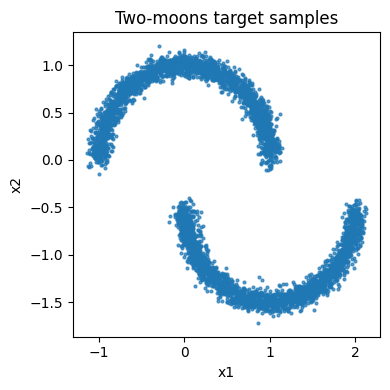

In [2]:
def make_two_moons(n, noise=0.06, seed=0):
    rng = np.random.default_rng(seed)
    n1 = n//2; n2 = n - n1
    t1 = rng.uniform(0, np.pi, size=n1)
    x1 = np.stack([np.cos(t1), np.sin(t1)], axis=1)
    t2 = rng.uniform(0, np.pi, size=n2)
    x2 = np.stack([1.0 - np.cos(t2), -np.sin(t2) - 0.5], axis=1)
    X = np.vstack([x1, x2]) + noise * rng.standard_normal(size=(n,2))
    rng.shuffle(X)
    return torch.tensor(X, dtype=torch.float32)

X = make_two_moons(n_samples, noise=0.06, seed=42).to(device)
print("Data shape:", X.shape)

plt.figure(figsize=(4,4))
plt.scatter(X[:5000,0].cpu(), X[:5000,1].cpu(), s=4, alpha=0.7)
plt.title("Two-moons target samples"); plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

## RealNVP building blocks

Affine coupling layer with a binary mask `m` that keeps part of the input and
affinely transforms the rest. Triangular Jacobian ⇒ cheap log-determinant.

In [8]:
class STNet(nn.Module):
    # Small MLP to predict scale 's' and shift 't' from the masked inputs
    def __init__(self, in_dim, out_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 2*out_dim),
        )
    def forward(self, x):
        st = self.net(x)
        s, t = torch.chunk(st, 2, dim=-1)
        return s, t

class CouplingLayer(nn.Module):
    def __init__(self, dim, mask, hidden=128, s_clip=3.0):
        super().__init__()
        self.register_buffer("mask", mask)
        in_dim  = int(mask.sum().item())
        out_dim = dim - in_dim
        self.st = STNet(in_dim, out_dim, hidden)
        self.s_clip = s_clip

    def forward(self, x):
        # x -> z (used in log_prob)
        x1 = x * self.mask
        x2 = x * (1 - self.mask)
        s, t = self.st(x1[:, self.mask.bool()])
        if self.s_clip is not None:
            s = torch.tanh(s) * self.s_clip
        y2 = x2[:, (1 - self.mask).bool()] * torch.exp(s) + t
        y = x.clone()
        y[:, (1 - self.mask).bool()] = y2
        logdet = s.sum(dim=-1)
        return y, logdet

    def inverse(self, y):
        # y -> x (used in sampling)
        y1 = y * self.mask
        y2 = y * (1 - self.mask)
        s, t = self.st(y1[:, self.mask.bool()])
        if self.s_clip is not None:
            s = torch.tanh(s) * self.s_clip
        x2 = (y2[:, (1 - self.mask).bool()] - t) * torch.exp(-s)
        x = y.clone()
        x[:, (1 - self.mask).bool()] = x2
        logdet = -s.sum(dim=-1)
        return x, logdet

class RealNVP(nn.Module):
    def __init__(self, dim=2, n_layers=6, hidden=128, s_clip=3.0):
        super().__init__()
        self.dim = dim
        masks = []
        for i in range(n_layers):
            m = torch.zeros(dim)
            m[i % dim] = 1.0  # alternate which coord is passed-through
            masks.append(m)
        self.layers = nn.ModuleList([CouplingLayer(dim, m, hidden, s_clip) for m in masks])

    def f(self, x):
        # Forward transform: x -> z, accumulate log|det J|
        logdet = torch.zeros(x.size(0), device=x.device)
        z = x
        for layer in self.layers:
            z, ld = layer(z)
            logdet = logdet + ld
        return z, logdet

    def f_inv(self, z):
        # Inverse: z -> x
        x = z
        for layer in self.layers[::-1]:
            x, _ = layer.inverse(x)
        return x

    def f_inv_prefix(self, z, k):
        # Inverse through first k layers (for intermediate plots)
        x = z
        for layer in self.layers[:k][::-1]:
            x, _ = layer.inverse(x)
        return x

    def log_prob(self, x):
        z, logdet = self.f(x)
        log_p0 = -0.5 * (z**2).sum(dim=1) - self.dim*0.5*math.log(2*math.pi)
        return log_p0 + logdet

    def sample(self, n):
        z = torch.randn(n, self.dim, device=next(self.parameters()).device)
        return self.f_inv(z)

In [9]:
flow = RealNVP(dim=2, n_layers=n_layers, hidden=hidden_units, s_clip=s_clip).to(device)
print(flow)

RealNVP(
  (layers): ModuleList(
    (0-7): 8 x CouplingLayer(
      (st): STNet(
        (net): Sequential(
          (0): Linear(in_features=1, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_features=2, bias=True)
        )
      )
    )
  )
)


## Plotting helpers (intermediate steps, density, etc.)

In [5]:
@torch.no_grad()
def plot_intermediate_flow(flow, n_points=5000):
    z = torch.randn(n_points, 2, device=next(flow.parameters()).device)
    L = len(flow.layers)
    cols = min(4, L+1); rows = int(np.ceil((L+1)/cols))
    plt.figure(figsize=(4*cols, 4*rows))
    for k in range(L+1):
        if k == 0:
            xk = z.cpu(); title = "Base (z)"
        else:
            xk = flow.f_inv_prefix(z, k).cpu(); title = f"After {k} layer(s)"
        ax = plt.subplot(rows, cols, k+1)
        ax.scatter(xk[:,0], xk[:,1], s=4, alpha=0.5)
        ax.set_title(title); ax.set_xlim(-3,3); ax.set_ylim(-3,3); ax.set_aspect('equal', adjustable='box')
    plt.tight_layout(); plt.show()

@torch.no_grad()
def plot_data_and_density(flow, data, lim=3.0, grid_n=150):
    xs = data[:5000].cpu().numpy()
    grid = np.stack(np.meshgrid(np.linspace(-lim,lim,grid_n), np.linspace(-lim,lim,grid_n)), axis=-1).reshape(-1,2)
    grid_t = torch.tensor(grid, dtype=torch.float32, device=next(flow.parameters()).device)
    lp = flow.log_prob(grid_t).cpu().numpy().reshape(grid_n, grid_n)
    Xg, Yg = np.linspace(-lim,lim,grid_n), np.linspace(-lim,lim,grid_n)
    XG, YG = np.meshgrid(Xg, Yg)
    plt.figure(figsize=(5,4))
    plt.contourf(XG, YG, np.exp(lp), levels=40)
    plt.colorbar(label="density")
    plt.scatter(xs[:,0], xs[:,1], s=5, c="k", alpha=0.4)
    plt.title("Data with learned density")
    plt.xlim(-3,3); plt.ylim(-3,3); plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout(); plt.show()

## Train (maximum likelihood)
Minimize negative log-likelihood:  \(- \frac{1}{B} \sum_b \log p_\theta(x_b) \).

[  1] NLL: 1.9249


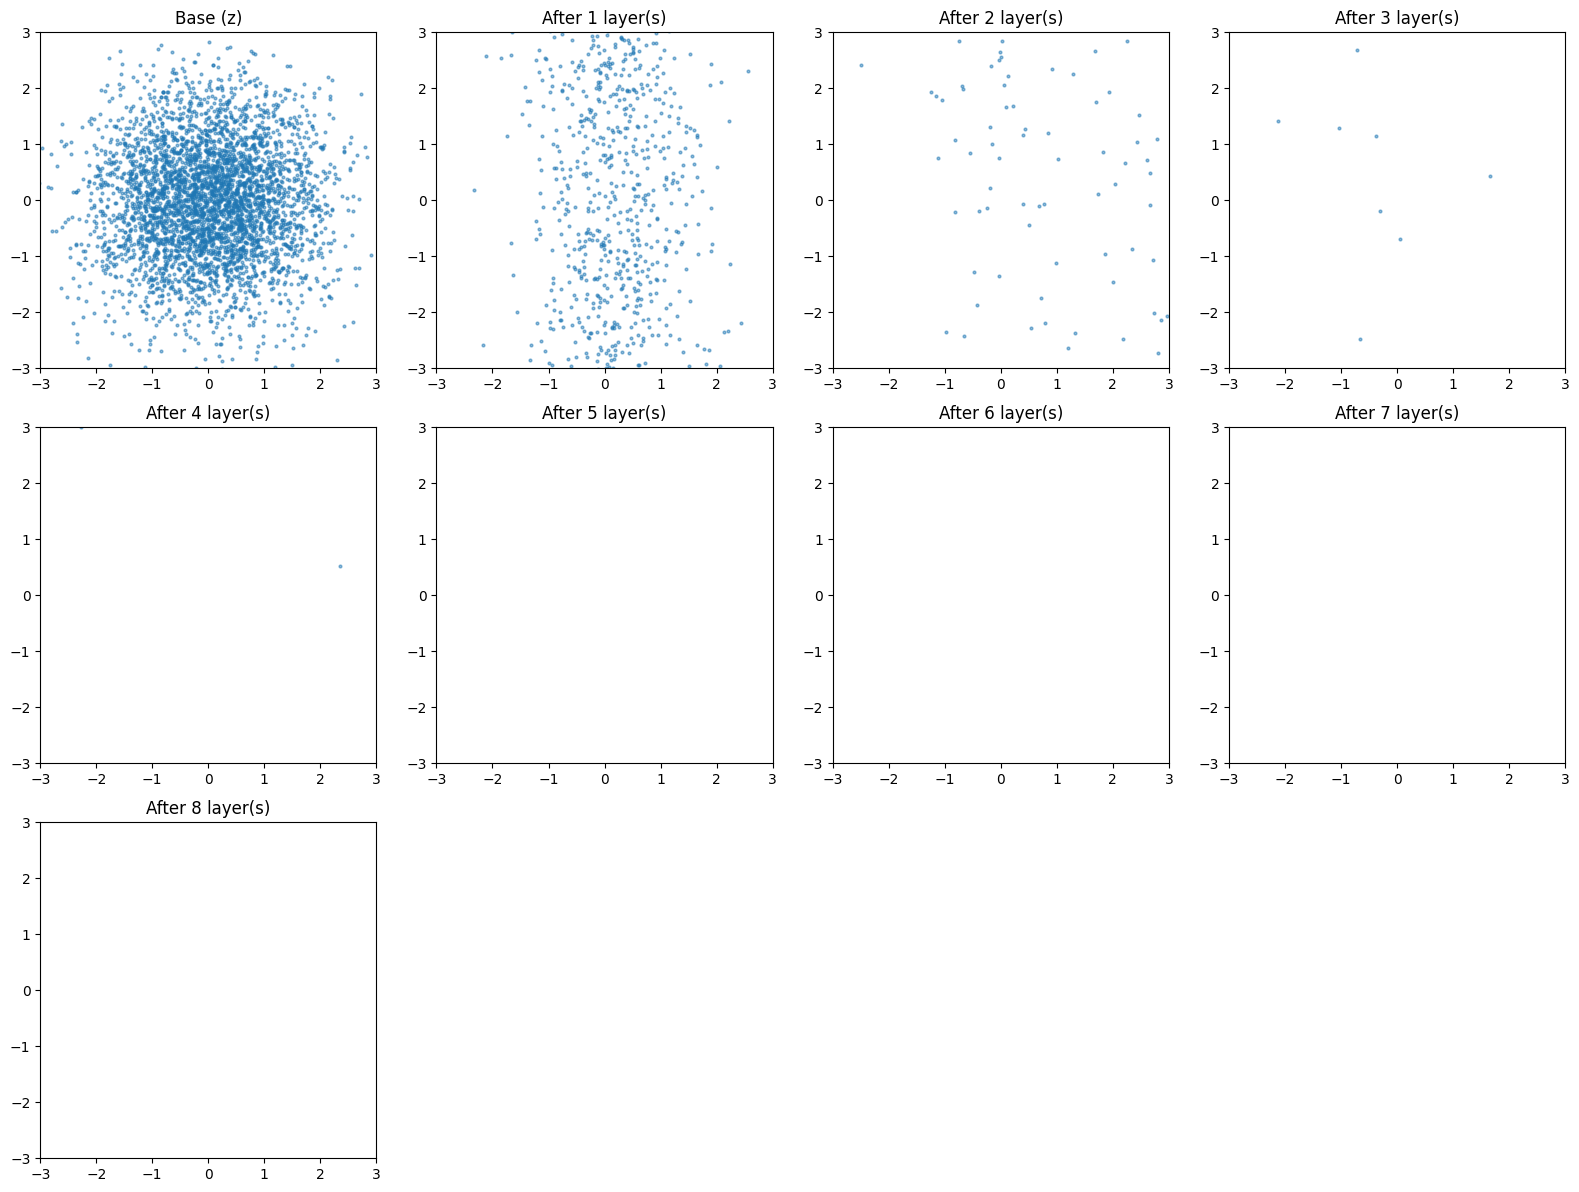

[  5] NLL: 1.8379
[ 10] NLL: 1.8379


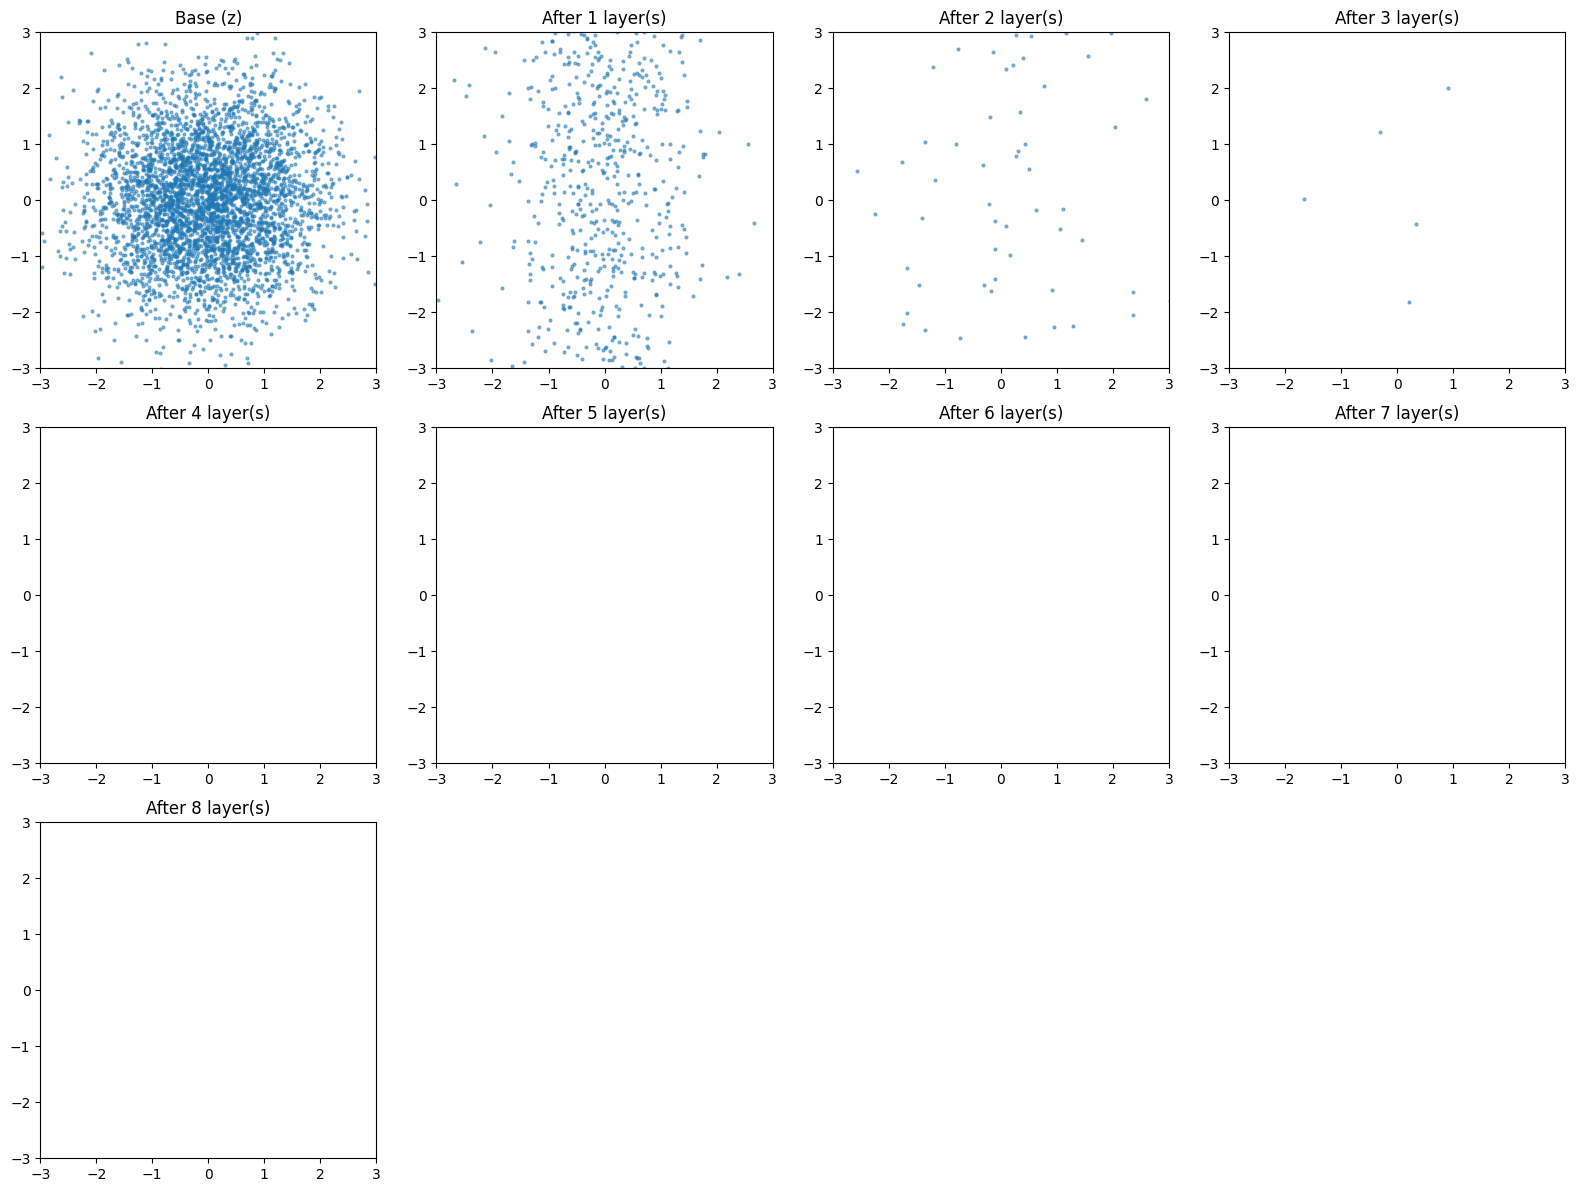

[ 15] NLL: 1.8379
[ 20] NLL: 1.8379


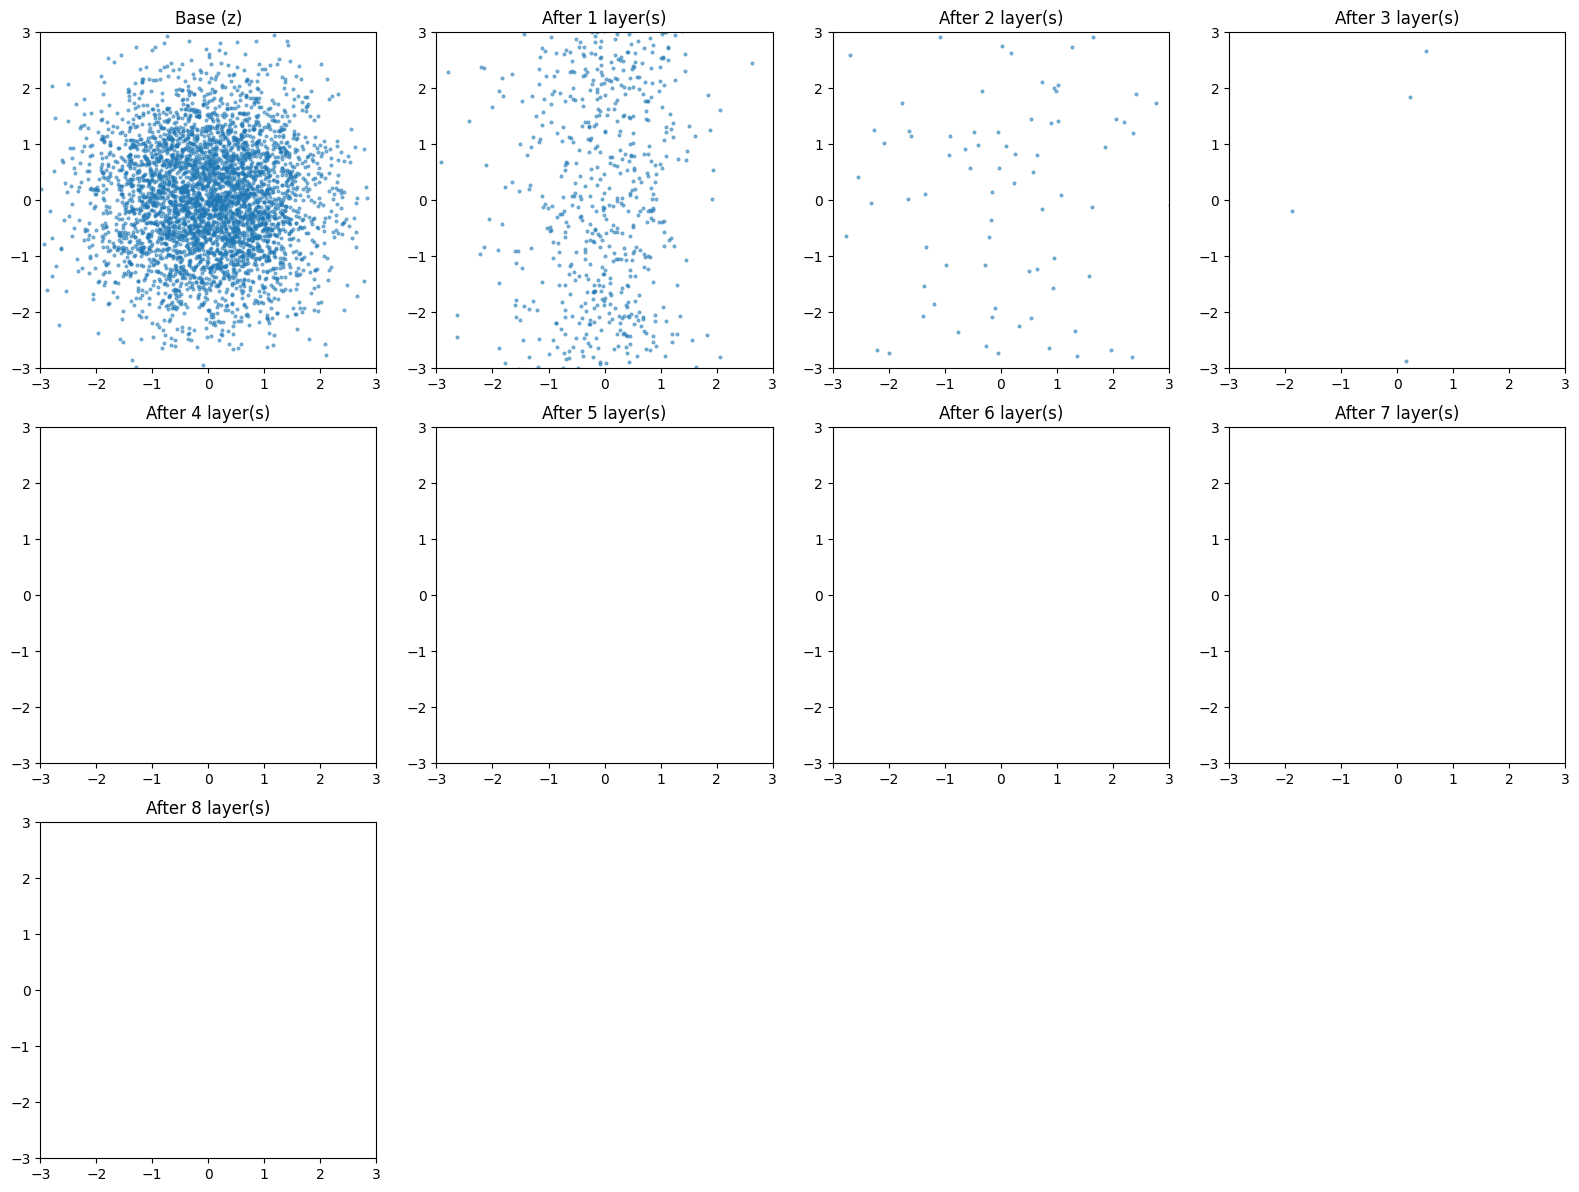

[ 25] NLL: 1.8379
[ 30] NLL: 1.8379


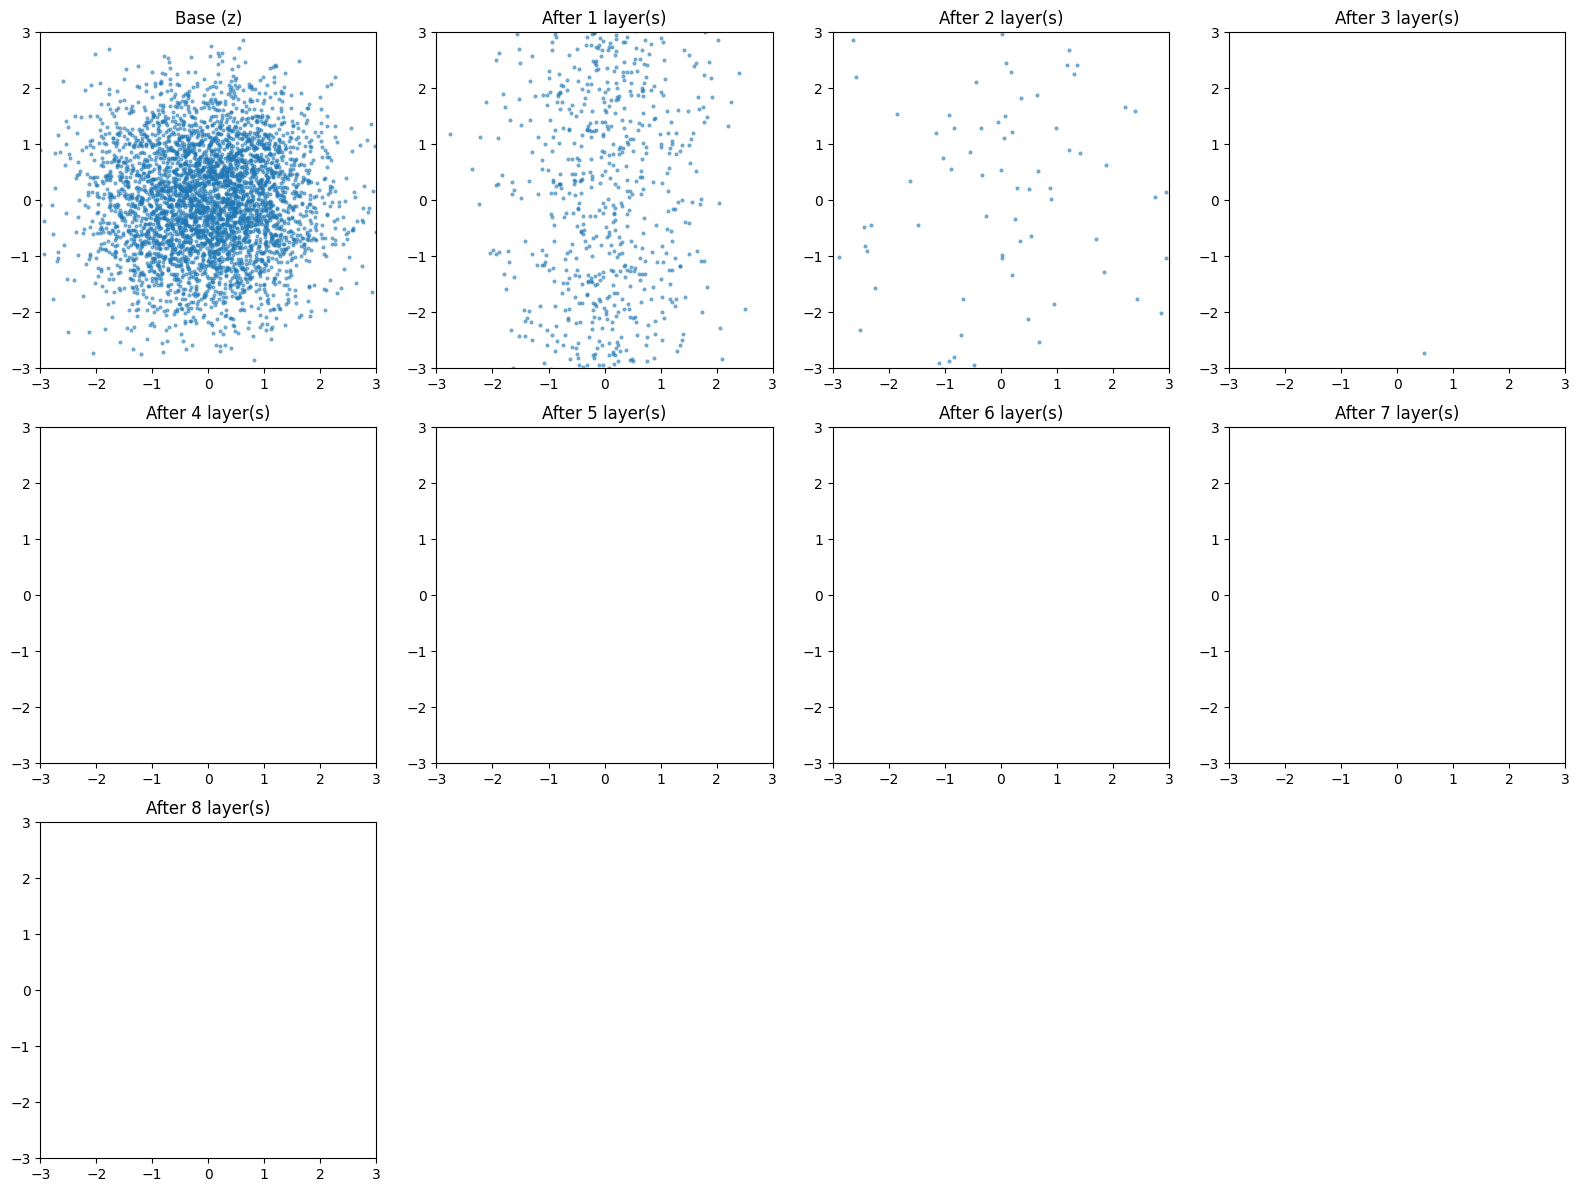

[ 35] NLL: 1.8379
[ 40] NLL: 1.8379


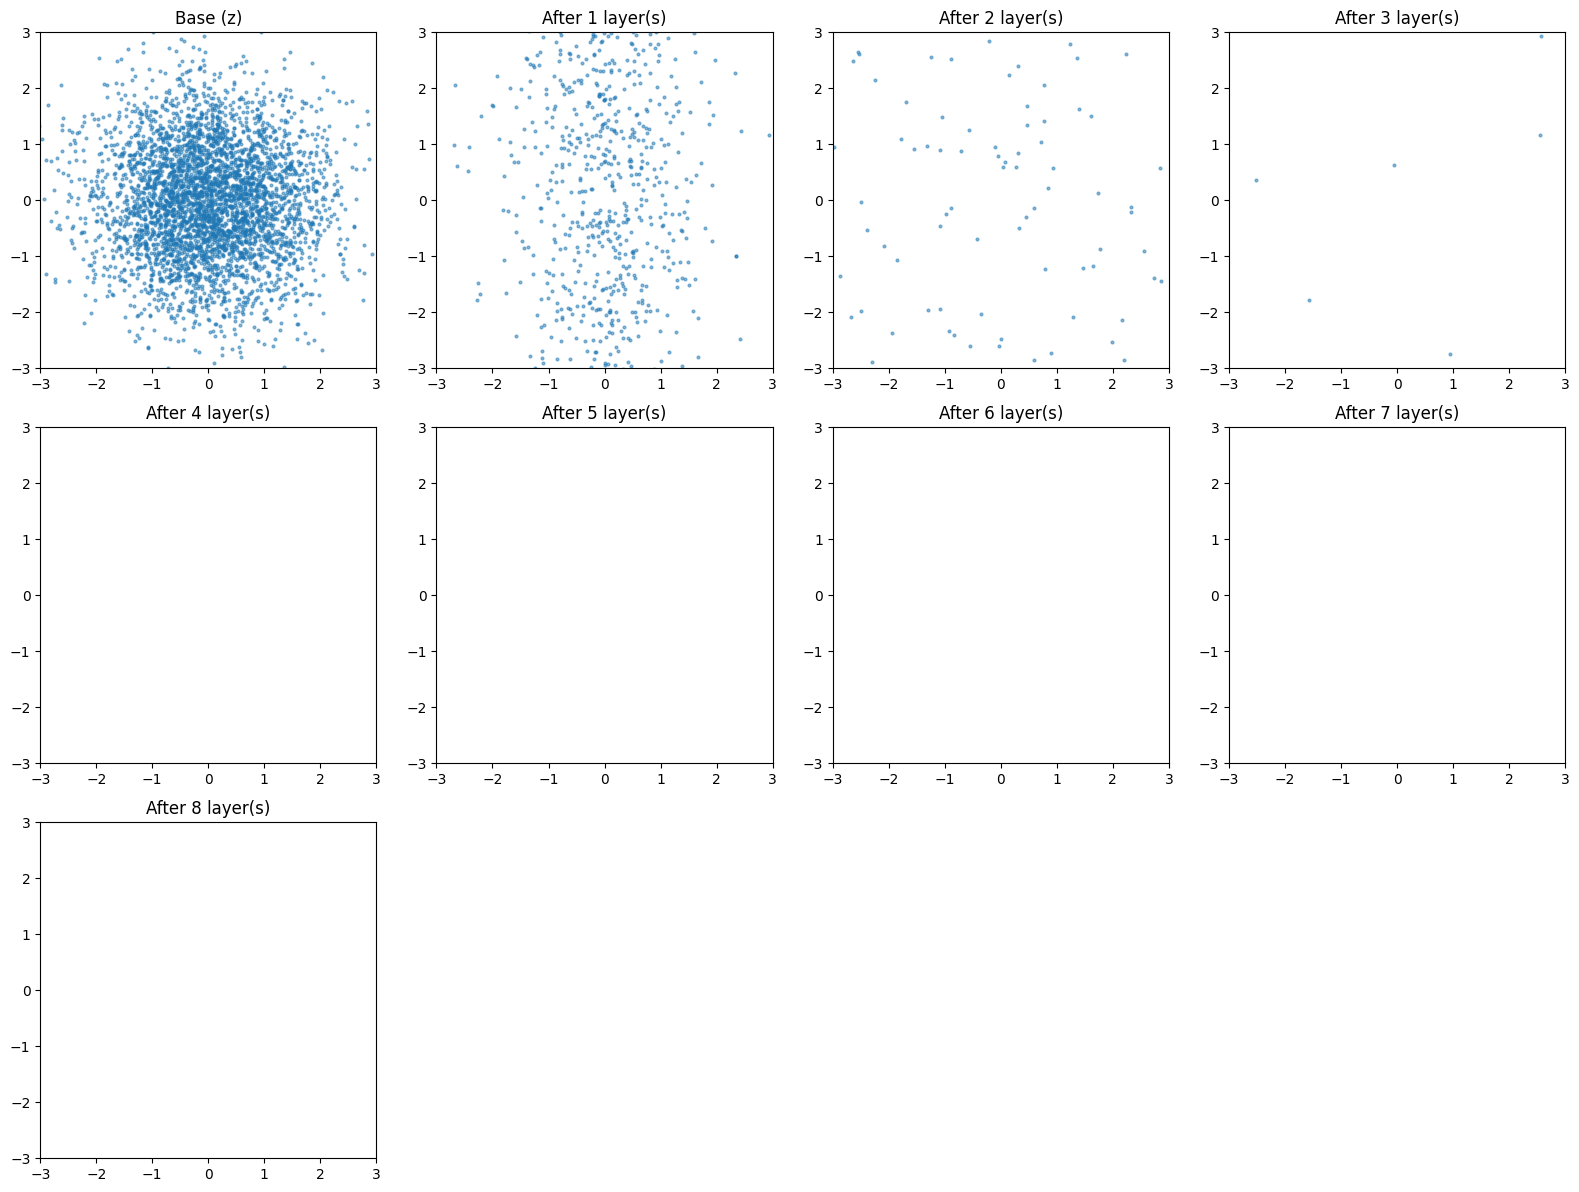

[ 45] NLL: 1.8379
[ 50] NLL: 1.8379


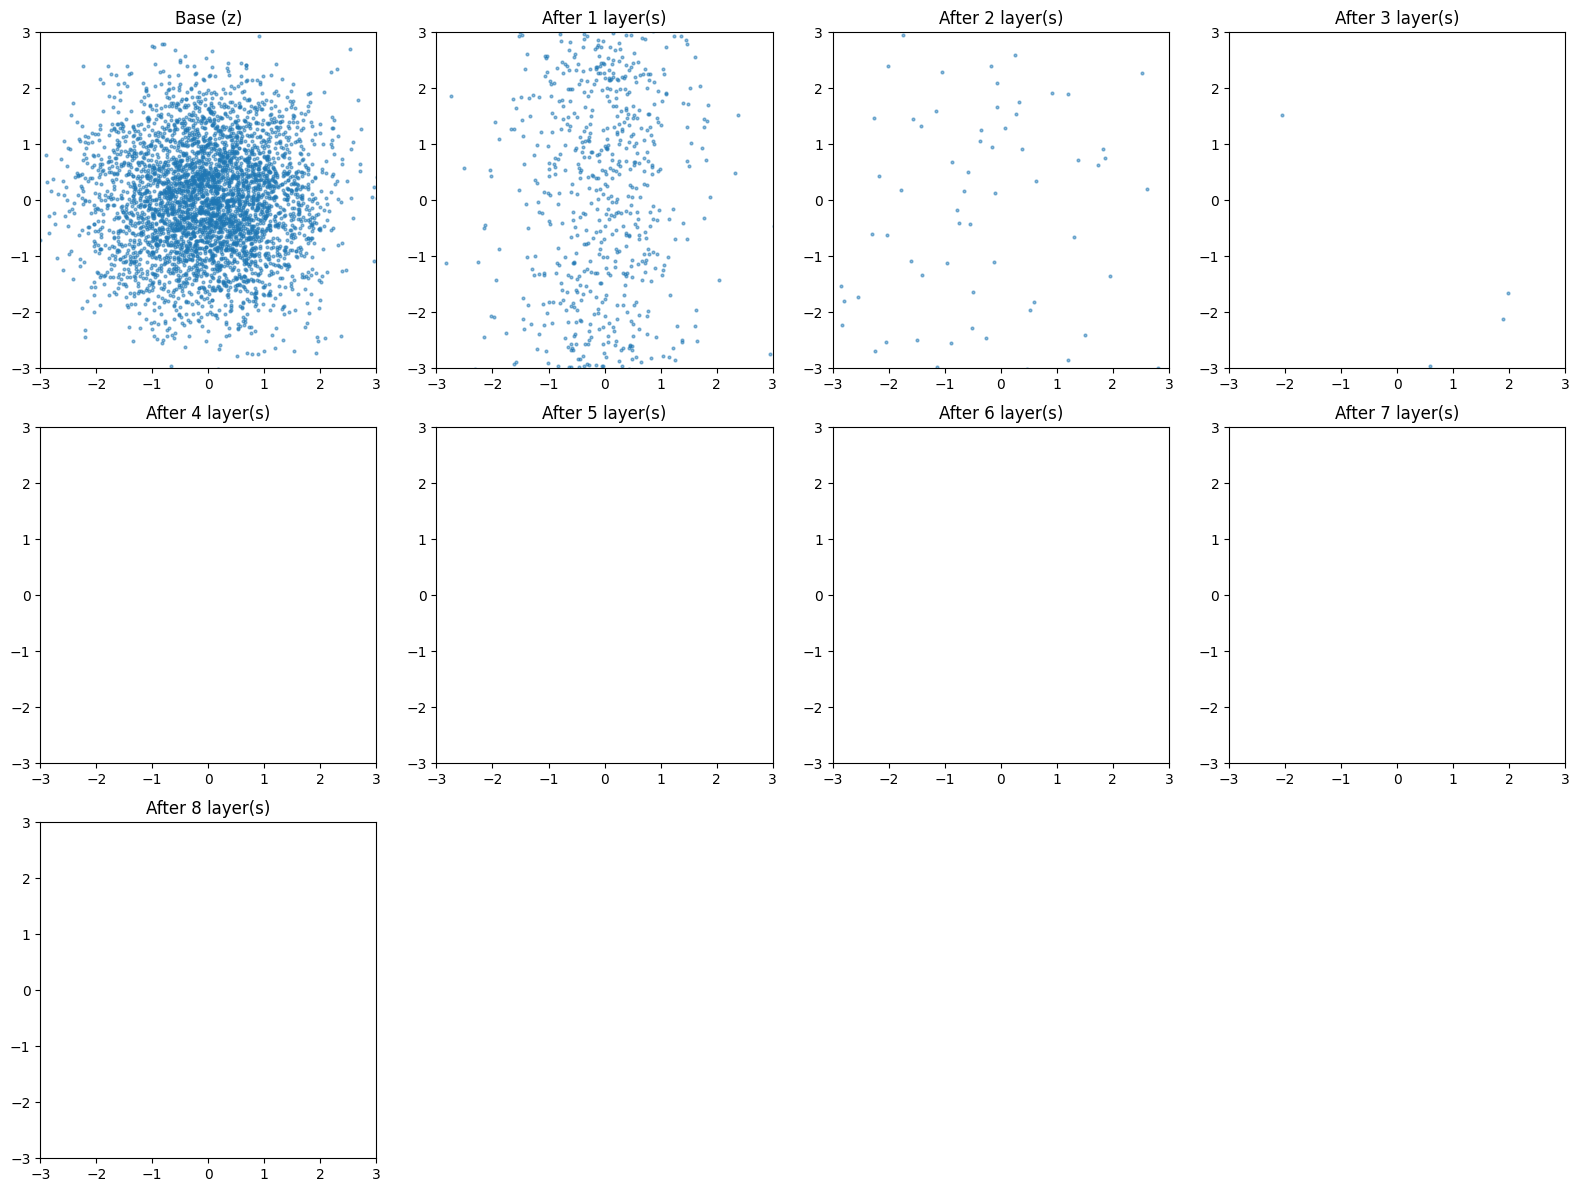

[ 55] NLL: 1.8379
[ 60] NLL: 1.8379


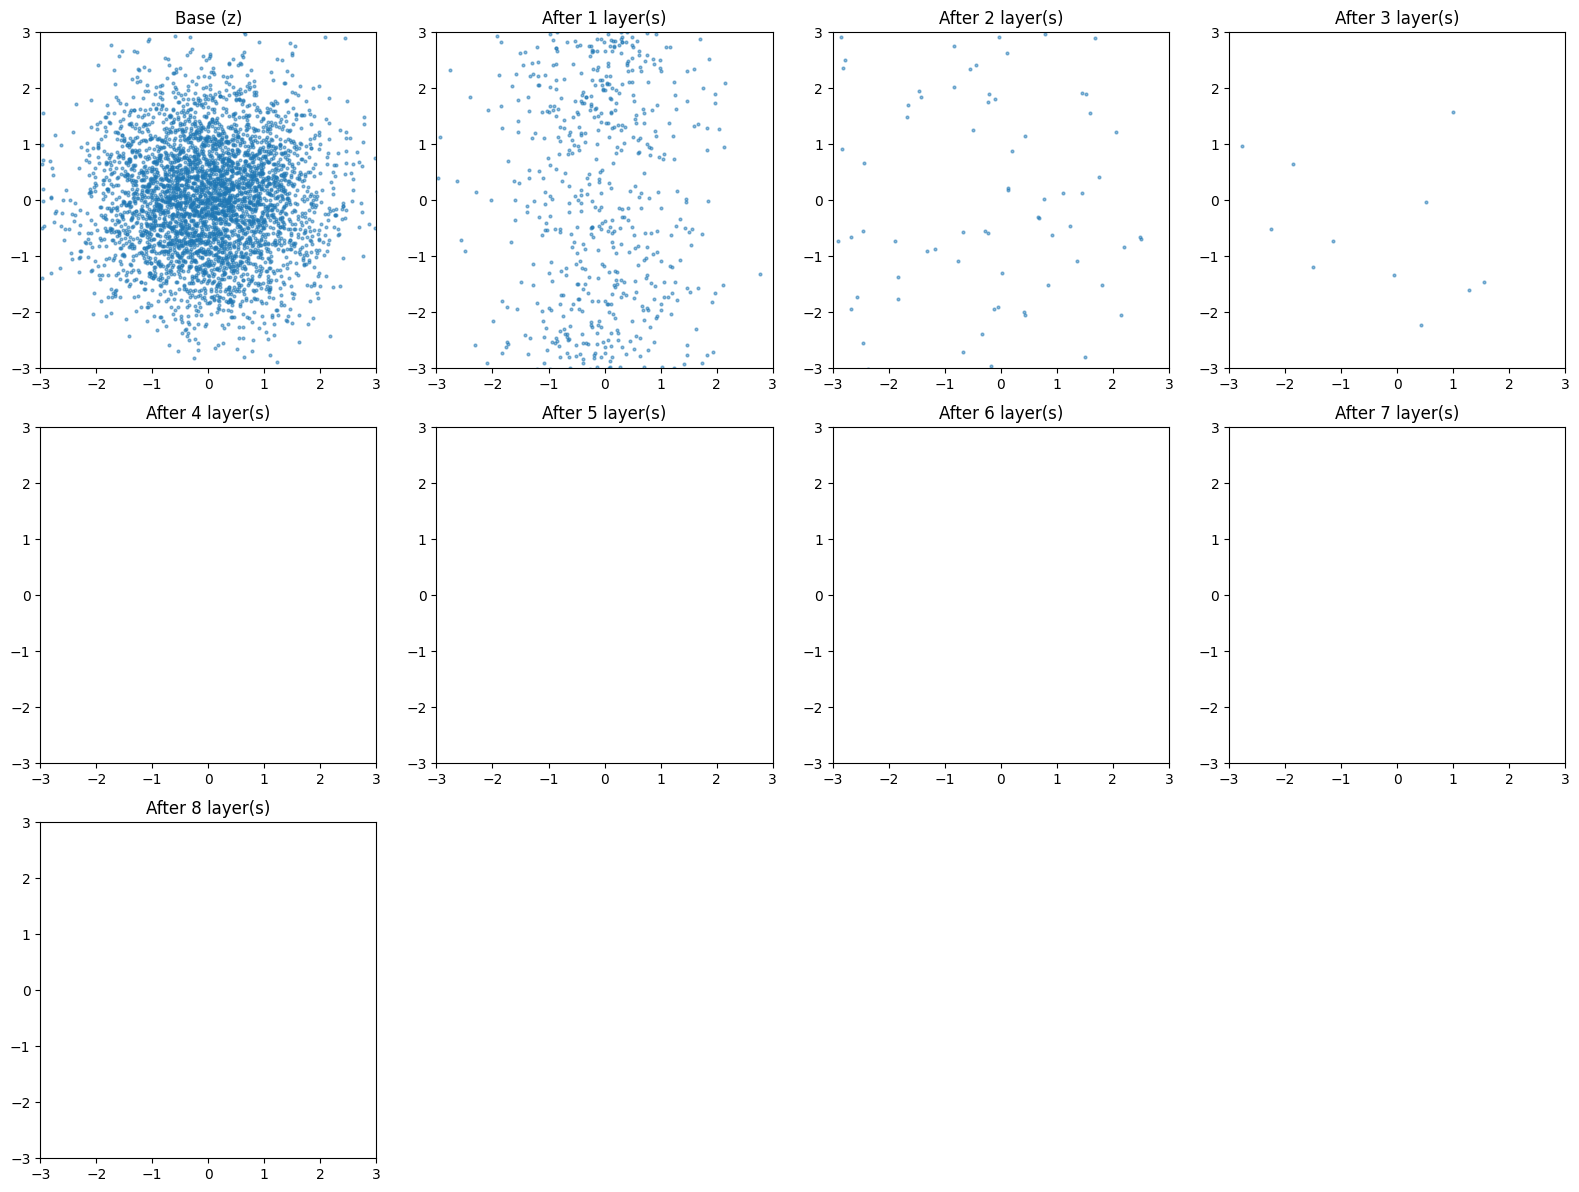

[ 65] NLL: 1.8379
[ 70] NLL: 1.8379


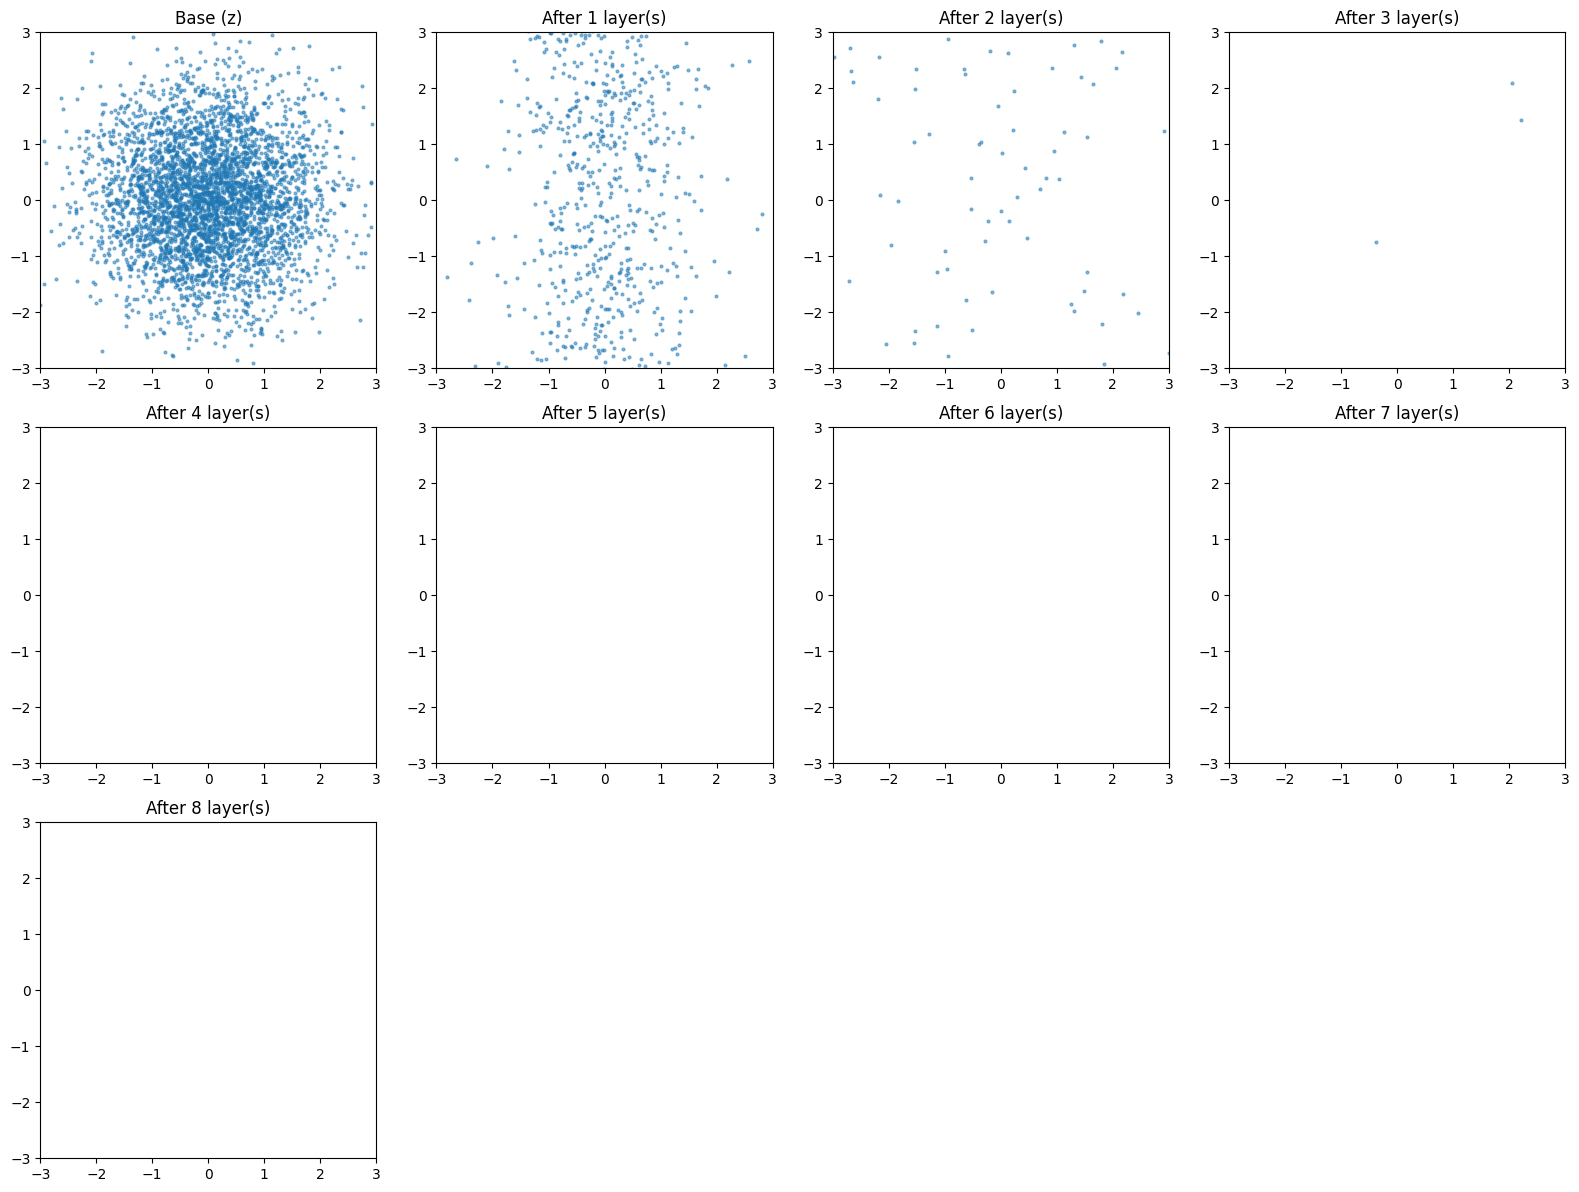

[ 75] NLL: 1.8379
[ 80] NLL: 1.8379


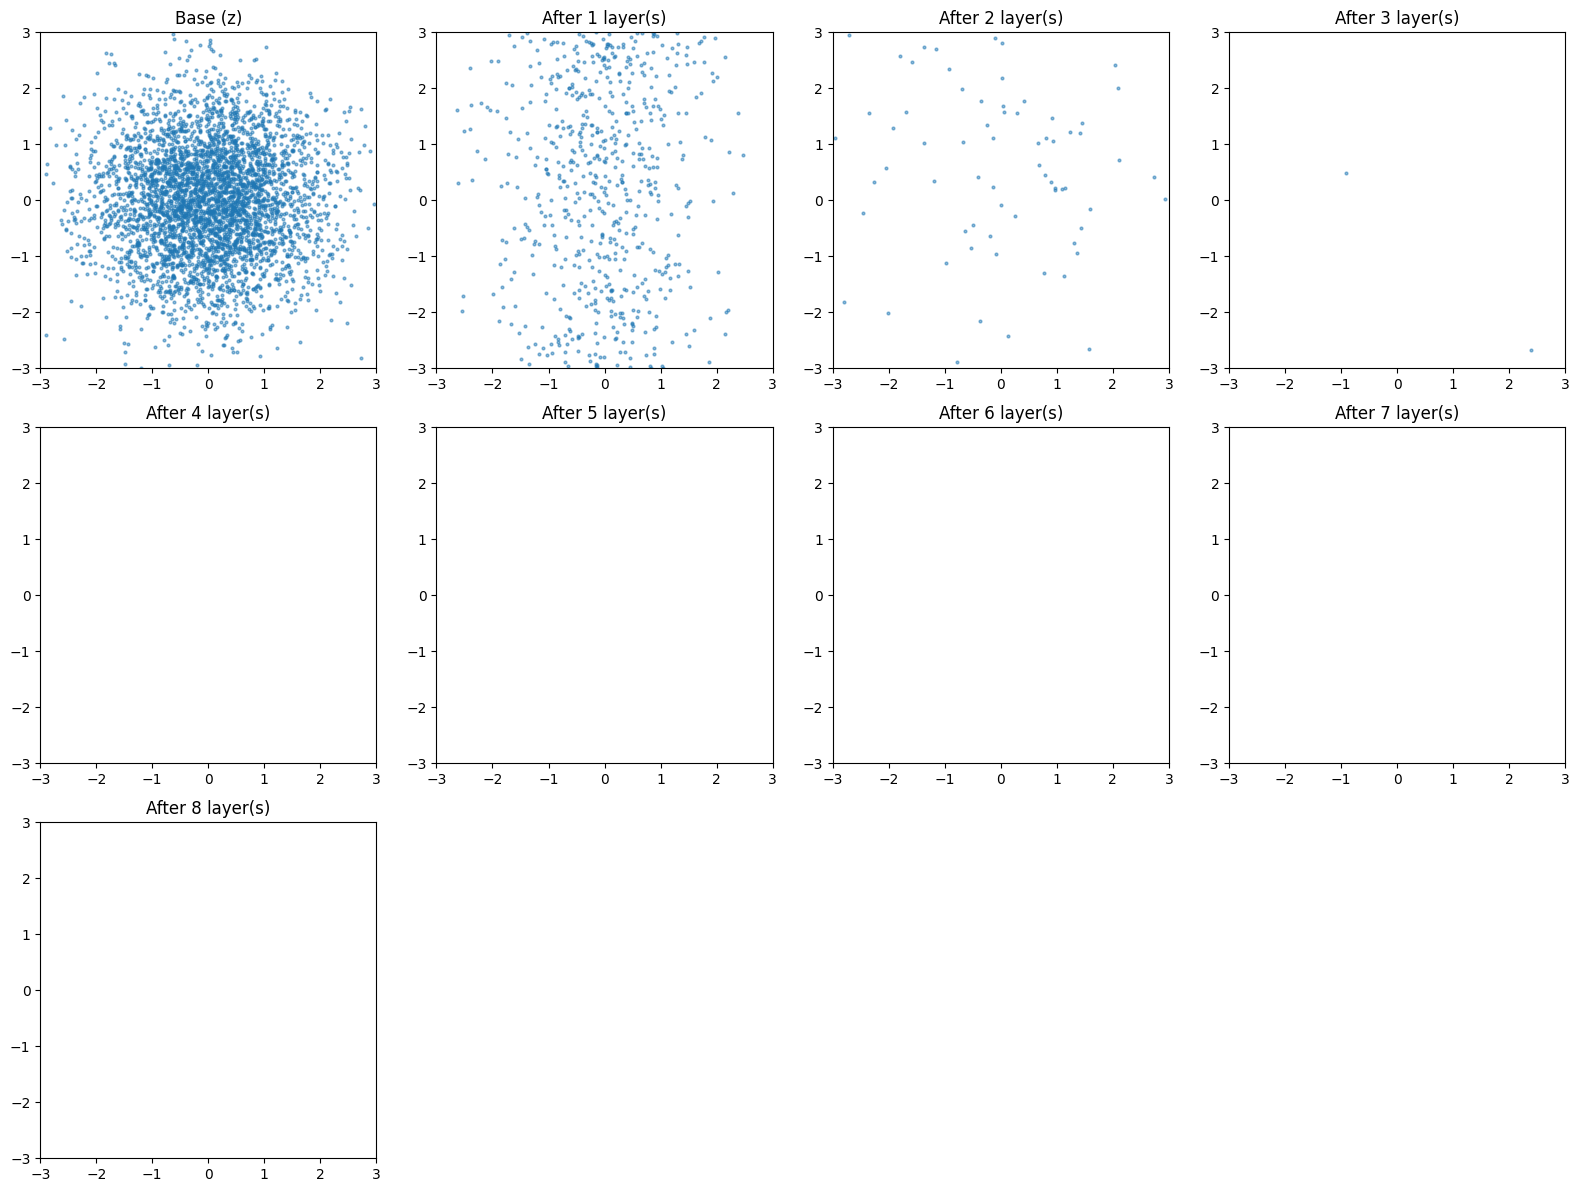

[ 85] NLL: 1.8379
[ 90] NLL: 1.8379


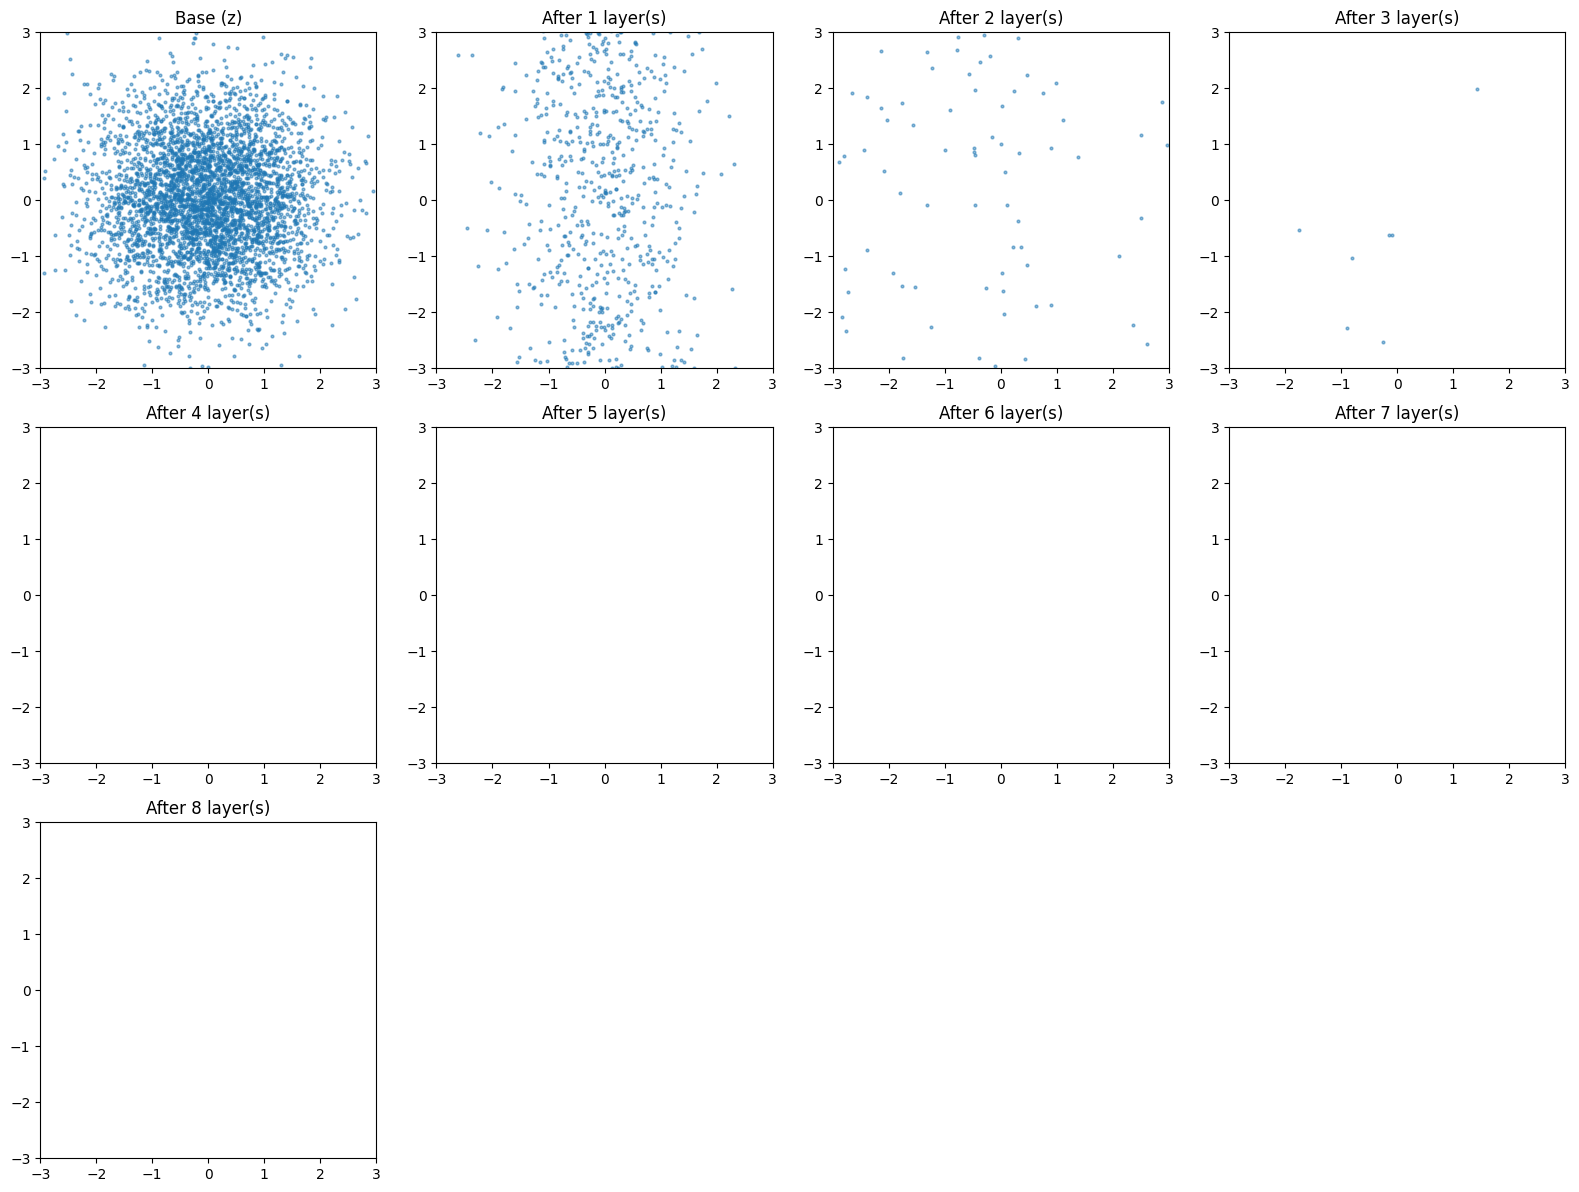

[ 95] NLL: 1.8379
[100] NLL: 1.8379


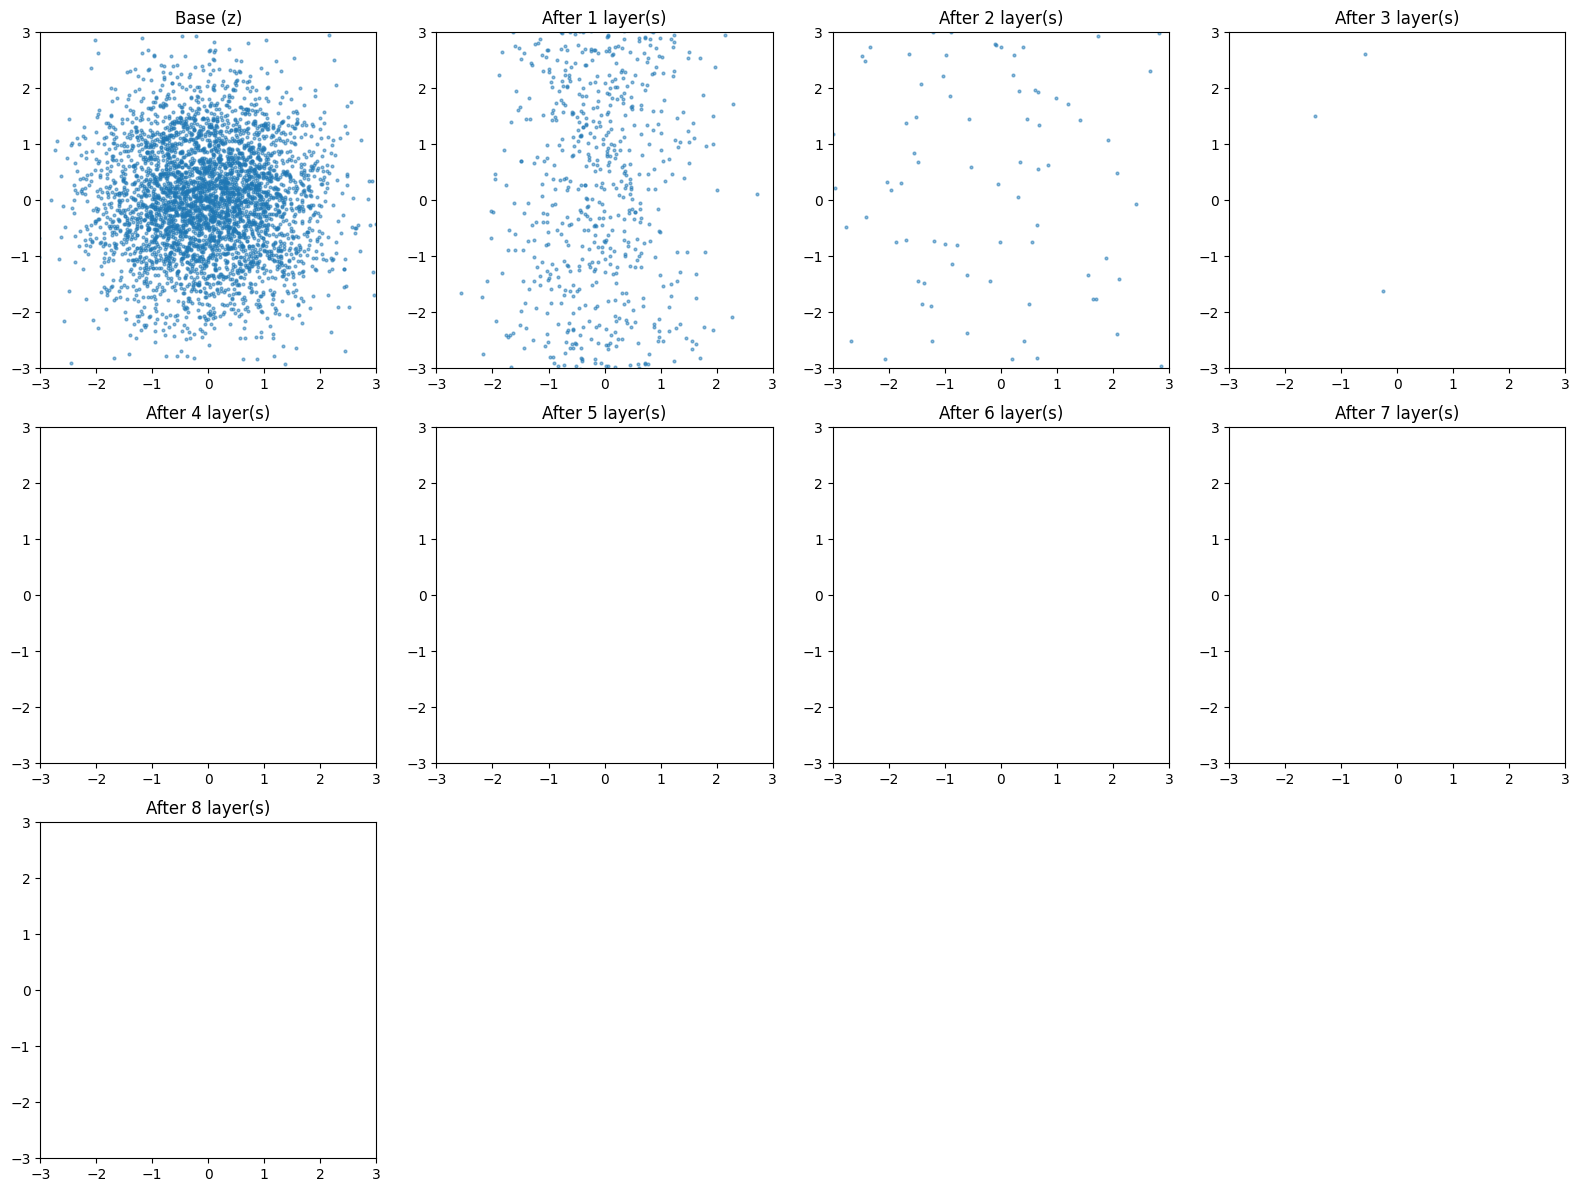

In [6]:
def train(flow, X, epochs=40, bs=512):
    opt = torch.optim.Adam(flow.parameters(), lr=lr)
    N = X.size(0)
    for ep in range(1, epochs+1):
        perm = torch.randperm(N, device=X.device)
        total_nll = 0.0
        for i in range(0, N, bs):
            xb = X[perm[i:i+bs]]
            loss = -flow.log_prob(xb).mean()
            opt.zero_grad(); loss.backward(); opt.step()
            total_nll += loss.item() * xb.size(0)
        if ep % 5 == 0 or ep == 1:
            print(f"[{ep:3d}] NLL: {total_nll/N:.4f}")
        if ep % plot_every == 0 or ep == 1:
            plot_intermediate_flow(flow, n_points=4000)
    return flow

flow = train(flow, X, epochs=epochs, bs=batch_size)

## Final diagnostics

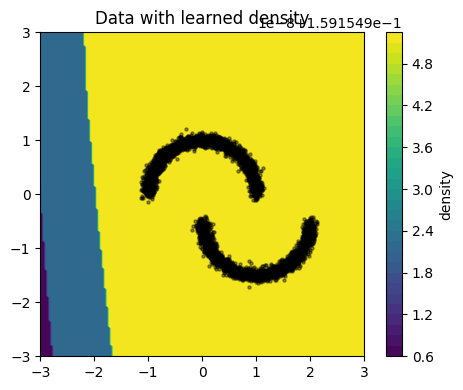

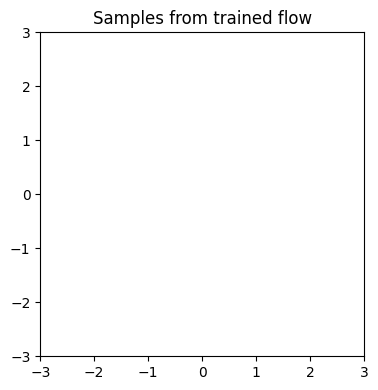

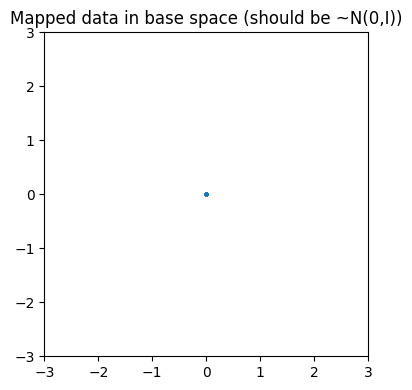

In [7]:
plot_data_and_density(flow, X, lim=3.0, grid_n=160)

with torch.no_grad():
    x_samp = flow.sample(6000).cpu().numpy()
plt.figure(figsize=(4,4))
plt.scatter(x_samp[:,0], x_samp[:,1], s=5, alpha=0.6)
plt.title("Samples from trained flow")
plt.xlim(-3,3); plt.ylim(-3,3); plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout(); plt.show()

with torch.no_grad():
    z_map, _ = flow.f(X)
z_np = z_map[:6000].cpu().numpy()
plt.figure(figsize=(4,4))
plt.scatter(z_np[:,0], z_np[:,1], s=4, alpha=0.6)
plt.title("Mapped data in base space (should be ~N(0,I))")
plt.xlim(-3,3); plt.ylim(-3,3); plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout(); plt.show()